<a href="https://colab.research.google.com/github/ReemAlsharabi/KAUST-Academy/blob/main/summer-program/week5/CV/Day3/Day3_ComputerVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Project 3: Sequence Modeling

<button disabled>

**Author:** Modar Alfadly, Guocheng Qian, Shuming Liu, and Mohammed Abugurain.

</button>

In the previous projects, you learned the basics of building, training, and evaluating deep learning models. In this project, we will pay some attention to handling data. Specifically, sequential data such as natural language (sequences of characters) and [videos](https://www.pyimagesearch.com/2019/07/15/video-classification-with-keras-and-deep-learning/) (sequences of images). The main challenge with this type of data is that input and output sequence lengths are variable. Previously, we more or less expected the input and output to always have fixed shapes. However, we did tackle one type of variability which was on the spatial dimensions. With fully convolutional networks, we are able to process images with virtually any size. In videos, one can think of extrapolating the idea of 2D convolutions to [3D](https://paperswithcode.com/method/3d-convolution) where the kernels move along the temporal dimension as well. Although that works in theory, training such monstrosity can easily become infeasible. This was a special case and we need a better tool to efficiently handle similar tasks with sequential nature.

Take for example the language translation task; the input is a sentence in language $A$ and the output is a sentence in language $B$. We notice that the number of words in the translated sentence doesn't need to be the same as the original sentence since languages have different characteristics. Moreover, not all sentences have a fixed length even in the same language. If we want to use what we learned so far, we will assume a maximum sequence length and appropriately apply padding and masking as we did with bounding boxes in object detection.

*Note:* you might be wondering how can we pass words to a neural network that accepts vectors of numbers not strings? A simple approach is to define a vocabulary (list of words) and represent each word with one-hot encoding or an [embedding vector](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding) that has [nice properties](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa) (e.g., close words semantically should be close in the embedding space). Such embedding can be learned using large corpus of text.

In [3]:
import math
import datetime
import sklearn
from pathlib import Path
import enum


from IPython import display
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, IterableDataset


import torchvision
import torchvision.transforms as T
from torchvision import models

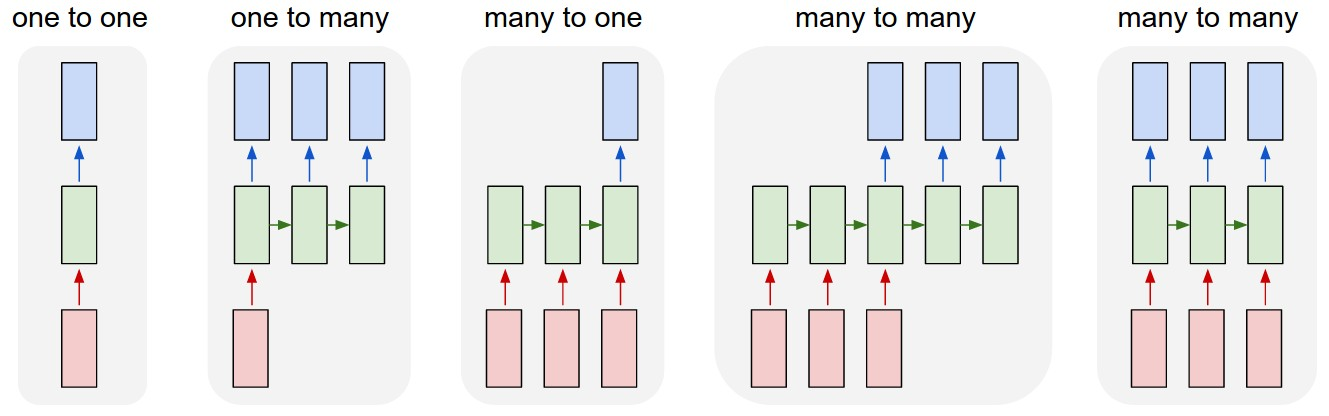

In sequential data, we will face various types of tasks. So far, we are familiar with one-to-one tasks. For example, image classification; the input (the bottom red block in the above figure) is a single image that is fed to the network (middle green block) and it spits a single output for the logits (top blue block). Although the logits are for multiple classes, we still consider them as one because it is the same for all possible inputs.

Examples of sequential data types:
- One-to-many: [image captioning](https://paperswithcode.com/task/image-captioning/) where the input is a single image and the output is a sentence describing the image
- Many-to-one: [text-to-image generation](https://paperswithcode.com/task/text-to-image-generation) where the input is a sentence describing a scene and the output is an image
- Many-to-many: language translation where the input and output sequnces don't necessarily have the same length
- Many-to-many (same length): noise cancelling in audio where the input and output have the same length

Before you start this project, you are highly encouraged to watch this [introductory video](https://www.youtube.com/watch?v=qjrad0V0uJE&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&index=2) and go through this [notebook](https://bit.ly/dl_for_cv_08).

# Part 1: Recurrent Neural Networks (4 points)

We cannot just simply train models for the maximum sequence length as they can be quite prohibitive. Instead, we will train a single recurrent cell; a single network that we apply on every element of the sequence. However, to incorporate the sequence, we will force the cell to accept a second input (other than sequence elements) we will call it the hidden state (the "memory" of the network if you will) and outputs an updated state. The hidden state acts as a feedback loop which is represented by the side arrows between the unrolled recurrent cells (green blocks). The first hidden state is initialized with zeros. Then, it gets updated by running through the sequence elements.

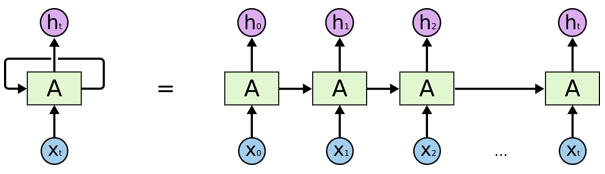

This seamingly simple idea is quite effective for such tasks. We can easily make this network deep by stacking RNNs cells.

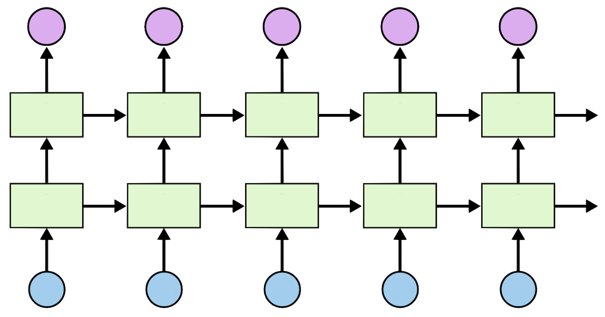

In some use cases, it might be beneficial to use information from future elements to get the desired output for current elements in the sequence. This manifests a lot in natural language were sometimes you need to wait until the end to understand the sentence. For example, to translate `spider man` to spanish `el hombre araña`, man `hombre` comes before spider `araña` and the netwok cannot translate spider first. Bidirectional RNNs try to alleviate this by stacking a second RNN cell working on the reverse direction.

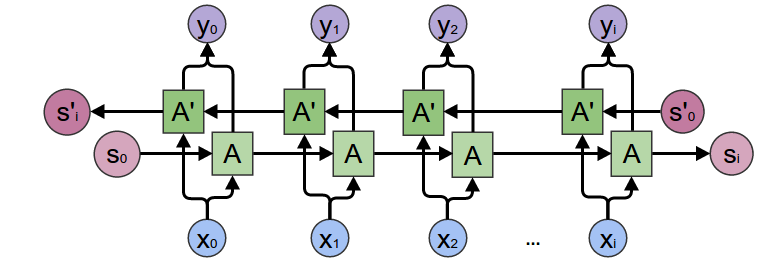

<h3>RNN</h3>

The only remaining thing that we didn't discuss is what goes inside this recurrent cell. The most basic version is the [Elman RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html#torch.nn.RNNCell). It applies a linear layer on the input and another linear layer on the hidden state and sum their results then apply an activation function; $\tanh$ in this case.

```python
input_to_hidden = nn.Linear(input_size, hidden_size)
hidden_to_hidden = nn.Linear(hidden_size, hidden_size)

new_hidden = torch.tanh(input_to_hidden(inputs) + hidden_to_hidden(hidden))
```

$$\begin{align}
    h_t &= \tanh\left((\mathbf{W}_{ih}\mathbf{x}_t+\mathbf{b}_{ih}) + (\mathbf{W}_{hh}\mathbf{h}_{t - 1}+\mathbf{b}_{hh})\right) & \text{(hidden state)}\\
\end{align}$$

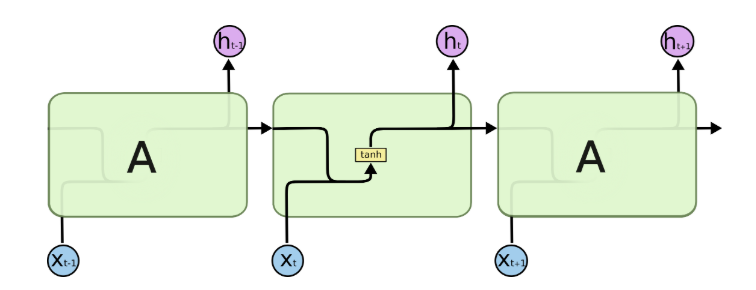

<h3>LSTM</h3>

The community came up with better recurrent cells since then. Most notably, Long Short-Term Memory ([LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html#torch.nn.LSTMCell)) and Gated Recurrent Unit ([GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRUCell.html#torch.nn.GRUCell)). For LSTMs, the intuition was to add "memory" features; forgetting irrelevant information $\rightarrow$ storing new information $\rightarrow$ updating the state.

$$\begin{align}
    i_t &= \sigma\left((\mathbf{W}_{ii}\mathbf{x}_t+\mathbf{b}_{ii}) + (\mathbf{W}_{hi}\mathbf{h}_{t - 1}+\mathbf{b}_{hi})\right) & \text{(input gate)}\\
    f_t &= \sigma\left((\mathbf{W}_{if}\mathbf{x}_t+\mathbf{b}_{if}) + (\mathbf{W}_{hf}\mathbf{h}_{t - 1}+\mathbf{b}_{hf})\right) & \text{(forget gate)}\\
    g_t &= \tanh\left((\mathbf{W}_{ig}\mathbf{x}_t+\mathbf{b}_{ig}) + (\mathbf{W}_{hg}\mathbf{h}_{t - 1}+\mathbf{b}_{hg})\right) & \text{(cell gate)}\\
    o_t &= \sigma\left((\mathbf{W}_{io}\mathbf{x}_t+\mathbf{b}_{io}) + (\mathbf{W}_{ho}\mathbf{h}_{t - 1}+\mathbf{b}_{ho})\right) & \text{(output gate)}\\
    c_t &= f_t \odot c_{t - 1} + i_t \odot g_t & \text{(cell state)} \\
    h_t &= o_t \odot \tanh(c_t) & \text{(hidden state)} \\
\end{align}$$

Watch this [video](https://www.youtube.com/watch?v=WCUNPb-5EYI) or read this [blog](http://dprogrammer.org/rnn-lstm-gru) for a detailed explanation of these components.

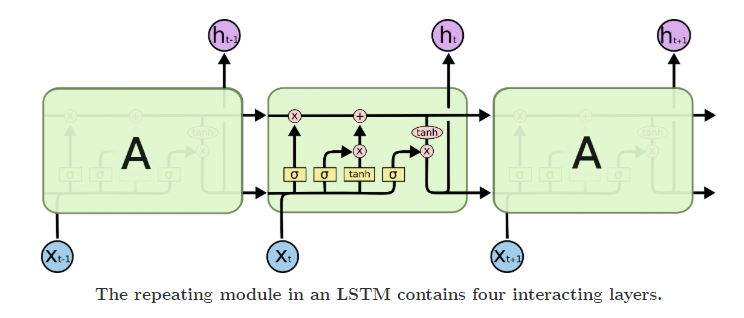

<h3>GRU</h3>

Notice how LSTMs add another state (in addition to the hidden state) called the cell state (top side link in the above figure). It helps the backpropagation step to handle long sequences as it offers a nice flow of gradients. GRUs tried to improve on this using simpler gates.

$$\begin{align}
    r_t &= \sigma\left((\mathbf{W}_{ir}\mathbf{x}_t+\mathbf{b}_{ir}) + (\mathbf{W}_{hr}\mathbf{h}_{t - 1}+\mathbf{b}_{hr})\right) & \text{(reset gate)}\\
    z_t &= \sigma\left((\mathbf{W}_{iz}\mathbf{x}_t+\mathbf{b}_{iz}) + (\mathbf{W}_{hz}\mathbf{h}_{t - 1}+\mathbf{b}_{hz})\right) & \text{(update gate)}\\
    n_t &= \tanh\left((\mathbf{W}_{in}\mathbf{x}_t+\mathbf{b}_{in}) + r_t \odot (\mathbf{W}_{hn}\mathbf{h}_{t - 1}+\mathbf{b}_{hn})\right) & \text{(new gate)}\\
    h_t &= (1 - z_t) \odot n_t + z_t \odot h_{t - 1} & \text{(hidden state)}\\
\end{align}$$

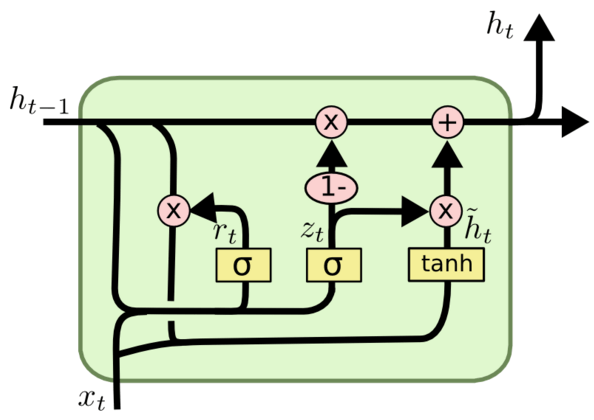

GRUs are computationally more efficient and they give similar performance to LSTMs. This is why we will primarily use them in this project. Luckily, all these models are implemented in PyTorch and you can use them directly. It also supports stacking and bidirectional RNNs. Here is an example that uses a GRU for a many-to-one task (i.e., given an input sequence, predict the class).

In [4]:
# many-to-one GRU model
class GRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=1, bidirectional=False):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, bidirectional=bidirectional, batch_first=True) # batch_first=True means that the first dimension of the input and output will be the batch size
        self.output = nn.Linear(hidden_size, num_classes)                                                   # nn.GRU returns two outputs: all_hidden_states, which is a tensor of size (batch_size, max_sequence_length, hidden_size) containing the hidden states for each time step in the input sequence, and last_hidden_state, which is a tensor of size (num_layers * num_directions, batch_size, hidden_size)

    def forward(self, x):
        # last_hidden_state is given as output for convenience
        all_hidden_states, last_hidden_state = self.gru(x)
        return self.output(last_hidden_state[-1]) # return the output of the last time step


def test():
    batch_size = 2
    max_sequence_length = 10
    input_size = 3
    hidden_size = 50 # number of neurons in the hidden layer
    num_classes = 7

    inputs = torch.randn(batch_size, max_sequence_length, input_size)
    print('Input shape:', inputs.shape) # (batch_size, max_sequence_length, input_size)
    net = GRUClassifier(input_size, hidden_size, num_classes)
    print('Output shape:', net(inputs).shape) # (batch_size, num_classes)

test()

Input shape: torch.Size([2, 10, 3])
Output shape: torch.Size([2, 7])


## Task 1.1: Many-to-Many Sequential Task (1 points)

In [5]:
# TODO: many-to-many GRU model
class GRUTranslation(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=1, bidirectional=False):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, bidirectional=bidirectional, batch_first=True)
        self.output = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # TODO: how can we implement a many-to-many sequential task (same input-output size)? (2 points)
        output, hn = self.gru(x) # Pass the entire sequence through the GRU layer
        output = self.output(output) # Apply the linear transformation to each output in the sequence

        return output
        # return self.output(...)

def test():
    batch_size = 2
    max_sequence_length = 10
    input_size = 3
    hidden_size = 50
    num_classes = 7

    inputs = torch.randn(batch_size, max_sequence_length, input_size)
    print('Input shape:', inputs.shape)
    net = GRUTranslation(input_size, hidden_size, num_classes)
    print('Output shape:', net(inputs).shape) # (batch_size, max_sequence_length, num_classes)

test()

Input shape: torch.Size([2, 10, 3])
Output shape: torch.Size([2, 10, 7])


Notice, how now the input has an extra dimension which is the sequence length `(seq_length, batch, features)`. Also, the batch dimension comes second after the sequence length. This is inconsistent to the convention that we are used to but it is more efficient under the hood. Nevertheless, the other option is also available using the `batch_first` argument. Another thing you should notice here is that `nn.GRU` uses a number of `nn.GRUCell`'s according to the `num_layers` and the `bidirectional` arguments. Let's reimplement a cell to check our understanding.

## Task 1.2: Forward Pass (3 points)

In [6]:
batch_size = 2
net = nn.GRUCell(7, 5) # input_size, hidden_size
net.eval()
x = torch.randn(batch_size, net.input_size)
h = torch.randn(batch_size, net.hidden_size)

w_ih, b_ih = net.weight_ih, net.bias_ih
w_hh, b_hh = net.weight_hh, net.bias_hh
print('w_ih:', w_ih.shape)
print('w_hh:', w_hh.shape)

# TODO: write the forward pass by your own using the weights from net (2 points)
# hint 1:
# internally, PyTorch combines all three linear layers of GRU
# that act on the input as a single linear layer and does the same
# for the hidden state layers given by w_ih and w_hh, respectively.

# hint 2:
# do the forward pass using F.linear() then split the output in the
# correct order and make sure that the output of net matches your h_t
r_i, z_i, n_i = F.linear(x, w_ih, b_ih).chunk(3, dim=1) # chunk() splits the tensor into chunks of size 3 along the dimension 1. F.linear is a linear transformation of the input x using the weight w_ih and bias b_ih
r_h, z_h, n_h = F.linear(h, w_hh, b_hh).chunk(3, dim=1) # why do we need to split the output of F.linear()?
## because F.linear() combines all three linear layers of GRU that act on the input as a single linear layer and does the same for the hidden state layers given by w_ih and w_hh, respectively.

# hint 3: follow the equations of GRUCell
r_t = torch.sigmoid(r_i + r_h)
z_t = torch.sigmoid(z_i + z_h)
n_t = torch.tanh(n_i + r_t * n_h)
h_t = (1 - z_t) * n_t + z_t * h

# Make sure returns True
print(torch.allclose(h_t, net(x, h))) # torch.allclose() returns True if two tensors are element-wise equal within a tolerance

w_ih: torch.Size([15, 7])
w_hh: torch.Size([15, 5])
True


# Part 2: Revisit CIFAR-10 Image Classification (2.5 points)
We have worked on CIFAR-10 in our first project, where we classify images using Conv2D. In this project, we revist CIFAR-10, this time we view an image as $16\times16$ patches and embed each patch to a vector $\mathbb{R}^C$. These embedded patches are called tokens. In this way, the classical image classification problem can be converted to a Many-to-One sequence modeling problem, where the input is the 256 tokens (257 tokens if we consider the class token) and the output should be the predicted logits.

In [7]:
from torch.utils.data import random_split
from torchvision import datasets


root_dir = Path(torch.hub.get_dir()) / f'datasets/CIFAR10'
normalize = T.Normalize(
    mean=(0.4915, 0.4823, 0.4468),
    std=(0.2470, 0.2435, 0.2616),
)

train_set = datasets.CIFAR10(
    root_dir,
    train=True,
    download=True,
    transform=T.Compose([
        T.ToTensor(),
        normalize,
    ]),
)
test_set = datasets.CIFAR10(
    root_dir,
    train=False,
    download=True,
    transform=T.Compose([
        T.ToTensor(),
        normalize,
    ]),
)

print(train_set)
print(test_set)

batch_size = 32

train_size = 40000
val_size = 10000

train_set, val_set = random_split(train_set, [train_size, val_size])



trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                        shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 46309352.73it/s]


Extracting /root/.cache/torch/hub/datasets/CIFAR10/cifar-10-python.tar.gz to /root/.cache/torch/hub/datasets/CIFAR10
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /root/.cache/torch/hub/datasets/CIFAR10
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /root/.cache/torch/hub/datasets/CIFAR10
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))
           )


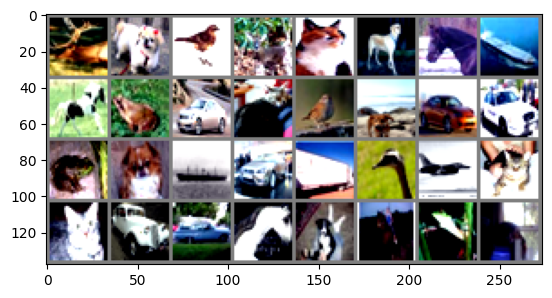

deer  dog   bird  deer  cat   dog   horse ship  horse frog  car   cat   bird  dog   car   car   frog  dog   ship  car   truck bird  plane cat   cat   car   car   horse dog   horse frog  cat  
torch.Size([3, 32, 32]) 3


In [9]:
# understand the data
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # simple unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.__next__()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
# print shape one image
# understand the data first.
img, lable = train_set.__getitem__(0)
print(img.shape, lable)

## Task 2.1: Patch Embedding (1 points)

In [10]:
# TODO: Patch embedding.
# Given CIFAR-10 image, convert it into 16x16 non-overlap patches (tokens) using 1 layer of 2d convolution.
# hint 1: The CIFAR-10 images are with shape 32x32
# hint 2: Reference, the ViT implementation here: https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
class PatchEmbed(nn.Module):
  def __init__(self, in_channels, embed_dim):
    super().__init__()
    self.proj = nn.Sequential(
      # todo: replace ... with 1 conv2d layer
      nn.Conv2d(in_channels, embed_dim, kernel_size=2, stride=2), # The convolutional layer with kernel size 2 and stride 2 will convert the 32x32 image into 16x16 patches. 32*32*1*1 = 16*16*2*2
      nn.Flatten(2), # flatten the last two dimensions of the tensor. This is done to convert the 16x16 patches into 256 dimensional vectors.
      )
    self.norm = nn.LayerNorm(embed_dim)

  def forward(self, x):
    return self.norm(self.proj(x).transpose(1, 2))
# test.
embed_dim = 64
patch_embed = PatchEmbed(3, embed_dim)
tokens = patch_embed(images)
print(images.shape, tokens.shape)

torch.Size([32, 3, 32, 32]) torch.Size([32, 256, 64])


## Task 2.2: Training a GRU-based Classifier (1.5 points)

<h3>TODOs:</h3>

- Copy the training and evaluation code from Project 2.
- Print the confusion matrix for training and testing at every epoch (0.5 points)
- Write a GRU-based image classifier. Hint: GRUClassifier + PatchEmbed (0.5 points)
- Reach over 80\% validation accuracy (0.5 points)

In [11]:
class ClassificationMetrics:
    """Accumulate per-class confusion matrices for a classification task."""
    metrics = ('accuracy', 'recall', 'precision', 'f1_score')

    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.tp = self.fn = self.fp = self.tn = 0

    @property
    def count(self):  # a.k.a. actual positive class
        """Get the number of samples per-class."""
        return self.tp + self.fn

    @property
    def frequency(self):
        """Get the per-class frequency."""
        # we avoid dividing by zero using: max(denominator, 1)
        # return self.count / self.total.clamp(min=1)
        count = self.tp + self.fn
        return count / count.sum().clamp(min=1)

    @property
    def total(self):
        """Get the total number of samples."""
        # return self.count.sum()
        return (self.tp + self.fn).sum()

    # @torch.no_grad()
    # def update(self, x, y):  # doesn't allow for "ignore_index"
    #     bincount = lambda x: torch.bincount(x, minlength=self.num_classes)
    #     self.tp += (tp := bincount(x[x == y]))
    #     self.fn += (fn := bincount(y) - tp)  # bincount(y[x != y])
    #     self.fp += (fp := bincount(x) - tp)  # bincount(x[x != y])
    #     self.tn += (tn := y.numel() - (tp + fn + fp))

    @torch.no_grad()
    def update(self, pred, true):
        """Update the confusion matrix with the given predictions."""
        pred, true = pred.flatten(), true.flatten()
        classes = torch.arange(0, self.num_classes, device=true.device)
        valid = (0 <= true) & (true < self.num_classes)
        pred_pos = classes.view(-1, 1) == pred[valid].view(1, -1)
        positive = classes.view(-1, 1) == true[valid].view(1, -1)
        pred_neg, negative = ~pred_pos, ~positive
        self.tp += (pred_pos & positive).sum(dim=1)
        self.fp += (pred_pos & negative).sum(dim=1)
        self.fn += (pred_neg & positive).sum(dim=1)
        self.tn += (pred_neg & negative).sum(dim=1)

    def reset(self):
        """Reset all accumulated metrics."""
        self.tp = self.fn = self.fp = self.tn = 0

    @property
    def accuracy(self):
        """Get the per-class accuracy."""
        # we avoid dividing by zero using: max(denominator, 1)
        return (self.tp + self.tn) / self.total.clamp(min=1)

    @property
    def recall(self):
        """Get the per-class recall."""
        # we avoid dividing by zero using: max(denominator, 1)
        return self.tp / (self.tp + self.fn).clamp(min=1)

    @property
    def precision(self):
        """Get the per-class precision."""
        # we avoid dividing by zero using: max(denominator, 1)
        return self.tp / (self.tp + self.fp).clamp(min=1)

    @property
    def f1_score(self):  # a.k.a. Sorensen–Dice Coefficient
        """Get the per-class F1 score."""
        # we avoid dividing by zero using: max(denominator, 1)
        tp2 = 2 * self.tp
        return tp2 / (tp2 + self.fp + self.fn).clamp(min=1)


    def weighted(self, scores):
        """Compute the weighted sum of per-class metrics."""
        return (self.frequency * scores).sum()

    def __getattr__(self, name):
        """Quick hack to add mean and weighted properties."""
        if name.startswith('mean_') or name.startswith('weighted_'):
            metric = getattr(self, '_'.join(name.split('_')[1:]))
            if name.startswith('mean_'):
                return metric.mean()
            else:
                return self.weighted(metric)
        raise AttributeError(name)

    def __repr__(self):
        """A tabular representation of the metrics."""
        metrics = torch.stack([getattr(self, m) for m in self.metrics])

        perc = lambda x: f'{float(x) * 100:.2f}%'.rjust(8)
        out = '   Class  ' + ' '.join(map(lambda x: x.rjust(7), self.metrics))

        out += '\n' + '-' * 53
        for i, values in enumerate(metrics.t()):
            out += '\n' + str(i).rjust(8) + ' '
            out += ' '.join(map(lambda x: perc(x.mean()), values))
        out += '\n' + '-' * 53

        out += '\n    Mean '
        out += ' '.join(map(lambda x: perc(x.mean()), metrics))

        return out

In [12]:
class Phase(enum.Enum):
    TRAINING = TRAIN = enum.auto()
    VALIDATION = VALID = VAL = enum.auto()
    TESTING = TEST = enum.auto()

def one_epoch(phase, model, loader, device, optimizer=None):
    metrics = ClassificationMetrics(num_classes=10)
    metrics.num_images = metrics.loss = 0  # adds extra values
    training = phase is Phase.TRAINING
    all_preds = []
    all_labels = []
    with torch.set_grad_enabled(training):
        model.train(training)
        for batch in loader:
            # move data to device
            # forward pass and loss computation
            images, labels = map(lambda x: x.to(device), batch)
            outputs = model(images)  # forward-pass
            loss = F.cross_entropy(outputs, labels)  # compute objective
            # ^^^^^^^^^^^^^^^^^

            # backward pass
            if training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # update batch metrics
            metrics.num_images += len(images)
            metrics.loss += loss.item() * len(images)
            metrics.update(outputs.data.argmax(dim=1), labels)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    metrics.loss /= metrics.num_images
    return metrics, cm


def train(model, train_loader, val_loader, optimizer, device, epochs):
    best_value = 0
    best_state = None
    last_best = 0
    patience = 5
    logs = []
    for epoch in range(epochs):
        print(f'Epoch: {epoch}'.ljust(11) + '#' * 42)
        train_metrics, cm_train = one_epoch(
            Phase.TRAINING,
            model,
            train_loader,
            device,
            optimizer,
        )
        print(f'TRAINING: Loss = {train_metrics.loss}')
        print(train_metrics, end='\n\n')
        print(f'Train Confusion Matrix:\n{cm_train}')


        val_metrics, cm_val = one_epoch(Phase.VALIDATION, model, val_loader, device)
        print(f'VALIDATION: Loss = {val_metrics.loss}')
        print(val_metrics, end='\n\n')
        print(f'Validation Confusion Matrix:\n{cm_val}')

        # add the metrics to the logs
        logs.append((train_metrics, val_metrics))

        current_value = train_metrics.weighted_accuracy
        if current_value >= best_value:
            last_best = 0
            best_value = current_value
            best_state = {
                'epoch': epoch,
                'model': model.state_dict(),  # save a copy of the parameters
                'optimizer': optimizer.state_dict(),  # TODO: Understand why we should save the optimizer parameters.
                'train_metrics': train_metrics,
                'val_metrics': val_metrics,
            }
            # here we can save the checkpoint to file if we want
            # torch.save(best_state, f'path/to/pf_segmentor_{epoch}.pt')
        else:
            last_best += 1
        # ^^^^^^^^^^^^^^^^^

        # early stopping if loss is NaN (not a number) or infinity
        if math.isnan(train_metrics.loss) or math.isinf(train_metrics.loss):
            print('Reached invalid loss! (no point in continuing)')
            break

        if last_best >= patience:
            print(f'Loss did not improve for {patience} epochs, stopping training.')
            break
        # ^^^^^^^^^^^^^^^^^
        print('#' * 53 + '\n')
    return best_state, logs

In [14]:
# TODO: training.
# Hint: we have worked on Image Classification before, you can simply copy the training code from previous projects.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
learning_rate = 3e-4
epochs = 10
embed_dim = 64
hidden_dim = 128
num_classes = 10 # 10 classes for CIFAR-10
num_layers = 10

class GRUImageClassifier(nn.Module):
    def __init__(
        self,
        in_channels,
        embed_dim,
        hidden_dim,
        num_classes,
        num_layers=1,
        bidirectional=False
    ):
        super().__init__()
        self.patch_embed = PatchEmbed(in_channels, embed_dim)
        self.gru_classifier = GRUClassifier(
            embed_dim, hidden_dim, num_classes, num_layers, bidirectional
        )

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.gru_classifier(x)
        return x


model = GRUImageClassifier(
    in_channels=3,
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    num_classes=num_classes,
    num_layers=num_layers
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-6)

# Do evaluation after training. The expected accuracy on validation set should be higher than 80%
best, logs = train(model, trainloader, valloader, optimizer, device, epochs)


# with torch.no_grad():
#     test_accuracy = gradient_descent(
#         model, (None, testloader), None, device, epochs=1)['accuracy'][0]
# print(f'Test accuracy of the last model {test_accuracy * 100:.2f}%')



Epoch: 0   ##########################################
TRAINING: Loss = 1.9399990678787231
   Class  accuracy  recall precision f1_score
-----------------------------------------------------
       0   87.80%   30.30%   37.14%   33.37%
       1   85.98%   30.25%   29.81%   30.03%
       2   88.27%    3.50%   14.34%    5.63%
       3   86.73%   12.36%   21.06%   15.58%
       4   84.21%   29.14%   25.20%   27.03%
       5   85.82%   21.29%   25.51%   23.21%
       6   84.78%   26.36%   25.32%   25.83%
       7   82.45%   34.86%   23.83%   28.31%
       8   85.52%   44.66%   33.04%   37.98%
       9   83.47%   42.37%   28.41%   34.02%
-----------------------------------------------------
    Mean   85.50%   27.51%   26.37%   26.10%

Train Confusion Matrix:
[[1222  274   95  105  166  118  104  402 1081  466]
 [ 136 1203   49  158   73   67  178  334  646 1133]
 [ 322  221  140  230  794  434  560  650  309  335]
 [ 162  354  104  490  332  702  534  505  297  483]
 [ 188  140  108  176 11

# Part 3: Transformers (3 points)

RNNs introduced the idea of a hidden state that is zero-initialized in the beginning and it gets updated as we process each element of the sequence in order. The problem with this, is that we need to wait for all previous elements to be processed first at every time step. An alternative approach was [proposed in 2017](https://arxiv.org/abs/1706.03762) and was named the [Transformer](https://en.wikipedia.org/wiki/Transformer_(machine_learning_model) model. It outperformed all recurrent models with impressive results at a memory and computational cost. Furthermore, new transformers were adapted to tackle different tasks such as image ([ViT](https://arxiv.org/abs/2010.11929)) and video ([VTN](https://arxiv.org/abs/2102.00719)) classification, object detection ([DETR](https://github.com/facebookresearch/detr)), semantic segmentation ([SETR](https://arxiv.org/abs/2012.15840)), and language generation ([GPT-3](https://openai.com/blog/openai-api/)). It has definitly become a main stream deep learning model showing a great potential not as [Capsule Networks](https://arxiv.org/abs/1710.09829). To alleviate the computational cost of transfomers, many models were proposed such as [Linformer](https://arxiv.org/abs/2006.16236) and [Longformer](https://arxiv.org/abs/2004.05150). It has a growing research community and [many](https://arxiv.org/abs/2006.16236) [imporvements](https://arxiv.org/abs/2103.03206) are yet to come.

Before you continue, you are highly encouraged to watch this [video](https://www.youtube.com/watch?v=iDulhoQ2pro) and/or read these [notes](http://nlp.seas.harvard.edu/2018/04/03/attention.html) explaining the first transformer model.

![alt text](https://d3i71xaburhd42.cloudfront.net/1831be99ff8d78575f3626c9750612fee7029c37/2-Figure3-1.png)

![alt text](https://vitalab.github.io/article/images/rcm/fig1.jpeg)

## Task 3.1: Get familar with Transformers (1.5 points)

In [15]:
batch_size = 4
max_seq_len = 100
feature_size = 64
x = torch.randn(batch_size, max_seq_len, feature_size)

# directly import transformer layer
net = nn.TransformerEncoderLayer(
    d_model=feature_size,
    nhead=4,  # must divides feature_size (why?)
    dim_feedforward=3,  # hidden size,
    batch_first=True
)
rnn = nn.GRU(feature_size, hidden_size=feature_size, batch_first=True)

print('Input shape :', x.shape)
print('Output shape:', net(x).shape)
print('RNN\'s shape :', rnn(x)[0].shape)  # all_states

Input shape : torch.Size([4, 100, 64])
Output shape: torch.Size([4, 100, 64])
RNN's shape : torch.Size([4, 100, 64])


As you can see from the above code, the basic building block of transformers is the [nn.TransformerEncoderLayer](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder). You can think of it as an equivalent to a recurrent cell (e.g., GRU) unrolling on the input sequence. The main difference is that the transformer layer is processing the entire sequence in parallel while the recurrent cell is doing it sequentially. The gotcha here is that the transformer layer doesn't know anything about the positions of the sequence elements. If you shuffle the input sequence order, the corresponding output will still be the same. This property is called permutation equivariance. This is definitely not the case with RNNs.

In [16]:
shuffle = torch.randperm(max_seq_len) # torch.randperm(max_seq_len) is a permutation of [0, 1, ..., max_seq_len - 1]
reorder = torch.empty_like(shuffle)
reorder[shuffle] = torch.arange(max_seq_len)
print(torch.allclose(x[:, shuffle][:, reorder], x))  # True
print(shuffle.shape)

# to avoid the possible numerical issue
x = x.double()
net = net.double()
rnn = rnn.double()
net.eval()
rnn.eval()

# TODO: vvvvvvvvvvv (0.5 points)
# verify that transformer is permutation equivariant
# also, check that it does matter for RNNs (use the defined net and rnn)
# take the above assertion as a hint
shuffled_x_t = net(x[:, shuffle])
print(torch.allclose(net(x[:, shuffle])[:, reorder] , net(x)))  # expect True for transformer
print(torch.allclose(rnn(x[:, shuffle])[0][:, reorder], rnn(x)[0]))  # expect False for RNN
# ^^^^^^^^^^^^^^^^^

True
torch.Size([100])
True
False


To remedy this caveat, we can apply a possitional encoding (i.e., add information about the position to every sequence element). A naive way of doing this is by adding the position index value to the features (i.e., add $i$ to all elements at position $i$ in the sequence). A more clever approach was proposed in the original paper which uses sine and cosine functions with different frequencies. See an implementation [here](https://github.com/pytorch/examples/blob/13acec6d7c78dacd5e1fe9b0b4a325e1d39abc15/word_language_model/model.py#L65-L106).

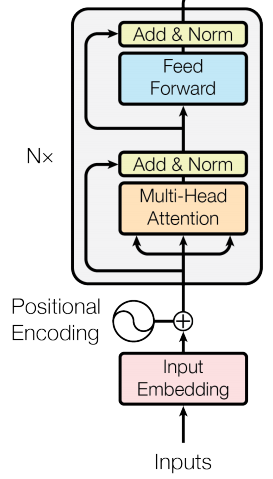

The above figure shows what is inside our transformer layer. It has a multi-head self-attention layer (the most important part) and two residual connections with [layer norm](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html#torch.nn.LayerNorm) in between. The "Nx" on the left simply represents stacking multiple transformer layers ([nn.TransformerEncoder](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder)). Nothing is new so far to us except for the attention block. In its simplest forms it looks like this (without any loss of generality and for ease of notation, assuming the input $\mathbf{x} \in \mathbb{R}^{N \times 1}$ is a sequence of length $N$ with a feature size of $1$):

$$\begin{align}
    \text{Attention}(\mathbf{q}, \mathbf{k}, \mathbf{v}) &= \text{softmax}\left(\frac{\mathbf{q}\mathbf{k}^\top}{\sqrt{N}}\right)\mathbf{v} \\
    \text{Self-Attention}(\mathbf{x}) &= \text{Attention}(\mathbf{W}_q\mathbf{x}+\mathbf{b}_q, \mathbf{W}_k\mathbf{x}+\mathbf{b}_k, \mathbf{W}_v\mathbf{x}+\mathbf{b}_v) \\
\end{align}$$

*Note*: the attention weights matrix ($\text{softmax}\left(\frac{\mathbf{q}\mathbf{k}^\top}{\sqrt{N}}\right) \in \mathbb{R}^{N \times N}$) is quadratic in size with respect to the sequence length.

In [17]:
x = torch.randn(batch_size, max_seq_len, feature_size)

# initialize the query, key, and value mapping
query = nn.Linear(feature_size, feature_size)
key = nn.Linear(feature_size, feature_size)
value = nn.Linear(feature_size, feature_size)

# TODO: implement the scaled dot-product attention as described in the equation (1 points)

d_k = feature_size ** 0.5 # Define the scaling factor for the dot product

q = query(x)  # shape (batch_size, max_seq_len, feature_size)
k = key(x)    # shape (batch_size, max_seq_len, feature_size)
dot_product = torch.matmul(q, k.transpose(-2,-1))  # shape (batch_size, max_seq_len, max_seq_len)


scaled_dot_product = dot_product / d_k # Scale the dot product by the square root of feature_size
attention_weights = torch.softmax(scaled_dot_product, dim=-1) # Apply a softmax activation function to get the attention weights


# Compute the weighted sum of the value vectors using the attention weights
attn =  value(x) # (batch_size, max_seq_len, max_seq_len). .traspose is a function to transpose the last two dimensions of a tensor
out = torch.matmul(attention_weights, attn) # (batch_size, max_seq_len, feature_size)

print('Input shape :', x.shape)
print('Output shape:', out.shape)

Input shape : torch.Size([4, 100, 64])
Output shape: torch.Size([4, 100, 64])


A [multi-head attention](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html#torch.nn.MultiheadAttention) is just a multiple attention models applied in parallel and their results are concatenated and followed by a linear layer. Purely for efficiency, the authors decided to reduce the number of output features for `query`, `key`, and `value` to be exactly the feature size divided by the number of heads. Therefore, the number of heads ($8$ in the paper) must divide the feature size ($512$ in the paper).

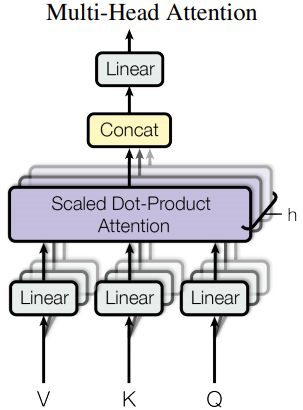

In a nutshell, attention is just a way to weigh the effect of every sequence element on every other sequence element. In vision transfomer (ViT) for example, the input image is cropped into 16x16 pixel patches that are passed to the network as a sequence (every patch is a sequence element with the patch position in the original image as the positional encoding). With this, every patch can attend to every other patch starting from the first layer. The receptive field is the entire image and the attention weight matrix intuitively represents how important every patch is to every other patch to classify the image (recall the size is of the attention matrix is $N \times N$).

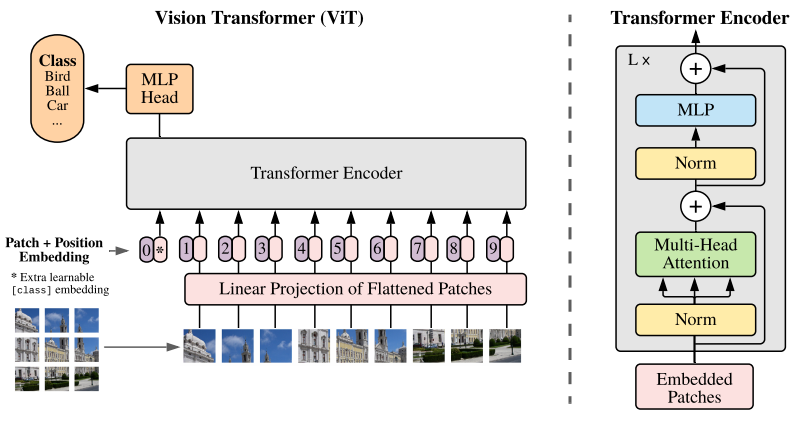

## Task 3.2: Build A ViT Model for Image Classification (2 points)

Similarly, we now can train an image classifier using Transformers. In this project, we focus on the ViT architecture from paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929). We only need to stack one patch embedding layer to embed the image as 256 tokens, followed by multiple transformer layers with a positional encoding on the input tokens in the middle, and a classifier head at the end. We can train it exactly as we did with RNNs. We do **NOT require training the ViT** at this time, since we want the students to put more effort into understanding the essences of RNNs and Transformers, and get a touch of the recent hot topic, vision transformers.

In [ ]:
# TODO: vvvvvvvvvvv (2 points)
# build ViT

class ViT(nn.Module):
  def __init__(self, in_channels=3, num_classes=10, embed_dim=64, num_patches=256):
    super().__init__()

    # step 1, build a patch embedding layer
    self.patch_embed = nn.Conv2d(in_channels, embed_dim, kernel_size=16, stride=16)
    self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

    # step 2, positional encoding layer. We use a simple learnable positional encoding
    self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

    # step 3, build a three-layer four-head TransformerEncoder using nn.TransformerEncoder

    encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=4)
    self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
    # step 4, build a linear classifier
    self.head = nn.Linear(embed_dim, num_classes)

    # final normalization layer
    self.norm = nn.LayerNorm(embed_dim)

  def forward(self, x):
    # forward pass here.
    x = self.patch_embed(x)
    x = torch.cat((self.cls_token.expand(x.shape[0], -1, -1), x), dim=1)
    # TODO: pass x into transformers
    x = x + self.pos_embed # Add the positional encoding to the input embeddings
    x = self.encoder(x) # pass x into transformer encoder
    x = self.norm(x) # pass x into the normalization layer
    return self.head(x[:, 0, :]) # why only use x[:, 0, :] ## because we only need the first token for classification

# test code.
x = torch.randn(batch_size, 3, 32, 32)
print('Input: ', x.shape)
vit = ViT()
print('Output:', vit(x).shape)
# ^^^^^^^^^^^^^^^^^

# Part 4: Further Reading (Optional, 0 Point)


Transformers work with any type of sequential data tasks. The exception is many-to-many with different sequence lengths between the input and the output as it needs extra care, e.g. image semantic **segmentation**. To do this, the full transformer model implements an encoder and a **decoder**.

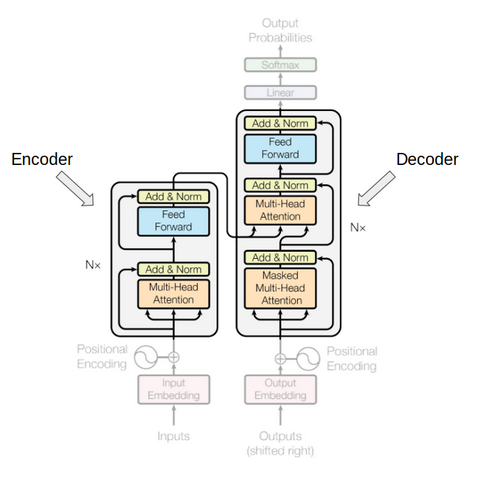

The final output of the encoder is considered as the memory which gets passed to every decoder block as `key` and `value` while `query` comes from the output. The last difference in the decoder that we need to point out is the masking of the attention weight matrix. Since the order doesn't matter in transformers and we should not attend to future output elements, a square subsequent mask needs to be applied. The entire transformer model with all its [layers](https://pytorch.org/docs/stable/nn.html#transformer-layers) is encapsulated in [nn.Transformer](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html#torch.nn.Transformer). It can be readily instantiated and trained.

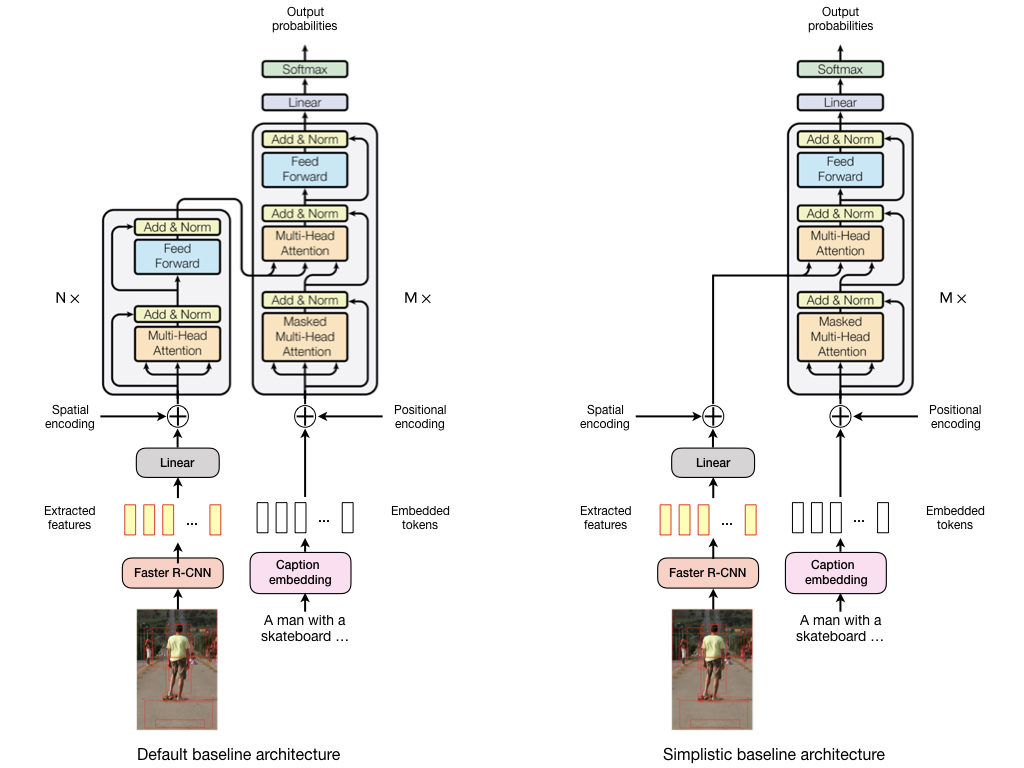

If you are interested to learn more about transformers, read this [survey paper](https://arxiv.org/abs/2101.01169) and checkout these applications:

- Language: [BERT](https://arxiv.org/abs/1810.04805), [GPT-3](https://arxiv.org/abs/2005.14165), [DeBERTa](https://arxiv.org/abs/2006.03654)
- Images: [IT](https://arxiv.org/abs/1802.05751), [ViT](https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html), [IPT](https://arxiv.org/abs/2012.00364), [BoTNet](https://arxiv.org/abs/2101.11605), [PVT](https://arxiv.org/abs/2102.12122), [iGPT](https://openai.com/blog/image-gpt/), [DETR](https://alcinos.github.io/detr_page/), [SETR](https://arxiv.org/abs/2012.15840)
- Video: [VTN](https://arxiv.org/abs/2102.00719), [TimeSformer](https://arxiv.org/abs/2102.05095)
- Point Clouds: [CT](https://arxiv.org/abs/2007.11679), [PT](https://arxiv.org/abs/2012.09164), [PCT](https://arxiv.org/abs/2012.09688)